# Q1

Build a complete pipeline with a data set of your choice and a tree-based model of your choice in R (using tidymodels) or Python (using scikit-learn). For each step, include a paragraph explaining why you did that step the way you did (what components were included and, possibly, what you decided not to do).

In [3]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import tqdm
from numpy import median
import random
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
%matplotlib inline

### 1. a brief description of where the data came from

The dataset we will use in this project is provided by Women in Data Science (WiDS Datathon) 2023 competition on Kaggle. This compeition focuses on forecasting weather in different regions within the US over a two-week period. Each row in the data corresponds to a single location and a single start date for the two-week period. **Our task is to predict the average temperature over the next 14 days, for each location and start date**.

### 2. some initial investigation of the data

In [4]:
df = pd.read_csv("train_data.csv", parse_dates=['startdate'], index_col=0)
df.head()

lat       lon  startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
index                                                                 
0      0.0  0.833333 2014-09-01                              237.00   
1      0.0  0.833333 2014-09-02                              228.90   
2      0.0  0.833333 2014-09-03                              220.69   
3      0.0  0.833333 2014-09-04                              225.28   
4      0.0  0.833333 2014-09-05                              237.24   

       nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
index                                                       
0                         29.02                     31.64   
1                         29.02                     31.64   
2                         29.02                     31.64   
3                         29.02                     31.64   
4                         29.02                     31.64   

       nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  \
index                                                     
0                        29.57                    30.73   
1                        29.57                    30.73   
2                        29.57                    30.73   
3                        29.57                    30.73   
4                        29.57                    30.73   

       nmme0-tmp2m-34w__cfsv20  nmme0-tmp2m-34w__gfdlflora0  ...  \
index                                                        ...   
0                        29.71                        31.52  ...   
1                        29.71                        31.52  ...   
2                        29.71                        31.52  ...   
3                        29.71                        31.52  ...   
4                        29.71                        31.52  ...   

       wind-vwnd-925-2010-11  wind-vwnd-925-2010-12  wind-vwnd-925-2010-13  \
index                                                                        
0                     -27.68                 -37.21                   8.32   
1                     -21.13                 -36.57                   8.77   
2                     -10.72                 -34.16                   6.99   
3                       0.33                 -31.04                   6.17   
4                       9.83                 -31.80                   7.47   

       wind-vwnd-925-2010-14  wind-vwnd-925-2010-15  wind-vwnd-925-2010-16  \
index                                                                        
0                       9.56                  -2.03                  48.13   
1                      21.17                   4.44                  48.60   
2                      32.16                   5.01                  48.53   
3                      39.66                  -1.41                  50.59   
4                      38.62                  -5.21                  54.73   

       wind-vwnd-925-2010-17  wind-vwnd-925-2010-18  wind-vwnd-925-2010-19  \
index                                                                        
0                      28.09                 -13.50                  11.90   
1                      27.41                 -23.77                  15.44   
2                      19.21                 -33.16                  15.11   
3                       8.29                 -37.22                  18.24   
4                      -2.58                 -42.30                  21.91   

       wind-vwnd-925-2010-20  
index                         
0                       4.58  
1                       3.42  
2                       4.82  
3                       9.74  
4                      10.95  

[5 rows x 245 columns]

The original dataset contains 375,734 observations, 244 features and one target variable `contest-tmp2m-14d__tmp2m`. According to the competition, `contest-tmp2m-14d__tmp2m` is the **arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date**.

In [5]:
print(f"There are {df.startdate.nunique()} unique startdates.") 

There are 731 unique startdates.


Data types:

In [6]:
df.dtypes.value_counts()

float64           240
int64               3
datetime64[ns]      1
object              1
dtype: int64

The dataset has one categorical variable `climateregions__climateregion`

In [7]:
df.climateregions__climateregion.value_counts()

BSk    139621
Dfb     52632
Cfa     51901
Csb     40936
Dfa     22661
BWk     13889
Dfc     12427
BWh      9503
Csa      9503
Dsb      8041
BSh      5117
Cfb      4386
Dsc      2924
Dwa      1462
Dwb       731
Name: climateregions__climateregion, dtype: int64

Plot temperature data by climate regions over the 731 startdates:

In [8]:
df_copy = df.copy()
region_median = pd.DataFrame(df_copy.groupby(by = ["startdate", "climateregions__climateregion"]).median()["contest-tmp2m-14d__tmp2m"])

def get_region_median(row):
    
    return region_median.loc[(row['startdate'], row['climateregions__climateregion']), 'contest-tmp2m-14d__tmp2m']


df_copy['region_median_temp'] = df_copy.apply(get_region_median, axis=1)

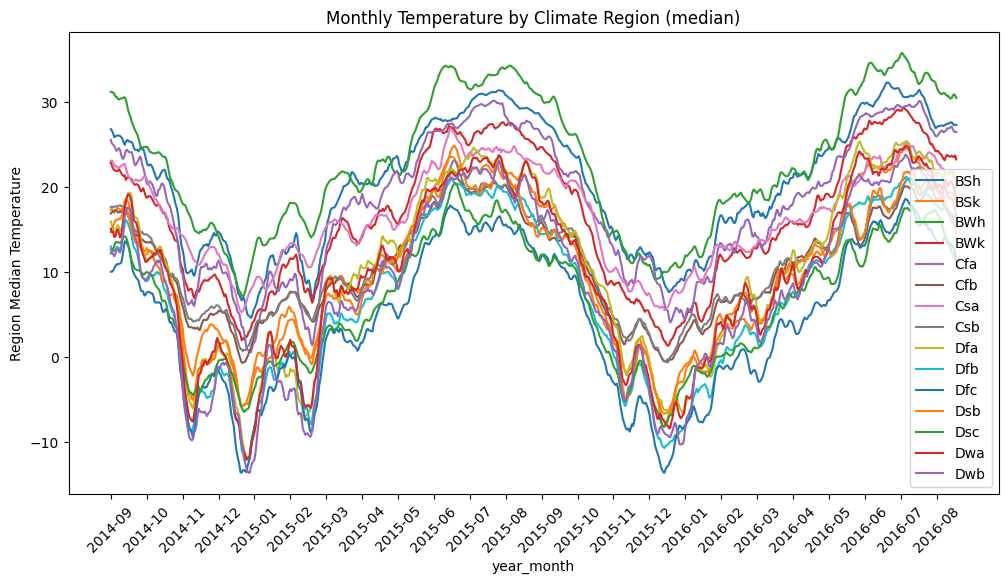

In [9]:
df_copy['year_month'] = pd.to_datetime(df_copy['startdate']).dt.to_period('m')

plot_temp = df_copy.pivot_table(index=["year_month","startdate"], columns="climateregions__climateregion", values="region_median_temp")
plot_temp.plot(figsize=(12,6))
plt.xticks(ticks=np.arange(0, 731, 31), labels=df_copy['year_month'].unique(), rotation=45)
plt.xlabel("year_month")
plt.ylabel("Region Median Temperature")
plt.title("Monthly Temperature by Climate Region (median)")
plt.legend(loc='best')


Our target varies a lot for different Climate regions, so climate region needs to be included as a categorical variable.

In [10]:
# delete some dataframes to free up some memory
del plot_temp
del region_median
del df_copy

### 3. preprocessing step(s)

First, the location data given are expressed in terms of longitude and latitude, we can turn this critical information into a more convenient format by creating location groups. A location group has its unique combination of longitude and latitude. However, to avoid having too many different groups, we choose to round the longitudes and latitudes down to contain 14 decimal places. 

In [11]:
def loc_group(df):
    
    scale = 14

    df['lat'] = np.round(df['lat'], scale)
    df['lon'] = np.round(df['lon'], scale)
    df['loc_group'] = df.groupby(['lon', 'lat']).ngroup()
     
    return df

In [12]:
df = loc_group(df)
df.loc_group.nunique()

514

We created in total 514 different location groups for which we will predict the average weather in the next 14 days.


In [13]:
n_startdates = []

for n in range(df.loc_group.nunique()):
    n_startdates.append(df[df.loc_group == n].startdate.nunique())

print(n_startdates)
print()
print(df.startdate.nunique())

[731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731,

We can see that each `loc_group` has 731 unique start dates and we have in total 731 unique start dates in the entire dataset, meaning all location groups have data for the same 731 start dates. This is a good thing because we have a balanced dataset for training models to forecast weather in different locations.  

Let's examine columns with missing values in the original dataset.

In [14]:
na_cols = []

for col in df.columns:
    if df[col].isnull().sum() >0:
        na_cols.append(col)
        print(col, df[col].isnull().sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


We fill in the missing values using the median value of a feature.

In [15]:
fillna_dict = {col: df[col].median() for col in na_cols}
df.fillna(fillna_dict, inplace=True)

In [16]:
df.isnull().sum().sum()

0

#### Train, Validation, and Test set split:

We sort the data used for fitting linear regressions by location group and start date. We split the data so that for each location group, data between 2014-09-1 and 2015-11-15 are used for training, data between 2015-11-15 and 2016-04-08 are used for validation, and data between 2016-04-08 and 2016-08-31 are used for testing. By doing so, we maintain a **6:2:2** ratio of train, validation, and test split.

In [17]:
df.sort_values(by=['loc_group', 'startdate'], inplace=True, ignore_index=True)

train = df[df["startdate"] <= pd.datetime(2015, 11, 15)]
val = df[(df["startdate"] > pd.datetime(2015, 11, 15)) & (df["startdate"] <= pd.datetime(2016, 4, 8))]
test = df[df["startdate"] > pd.datetime(2016, 4, 8)]

print(f'Train_shape: {train.shape}  |  Val_shape: {val.shape}   |  Test_shape: {test.shape}')

Train_shape: (226674, 246)  |  Val_shape: (74530, 246)   |  Test_shape: (74530, 246)


#### Feature Selection

The first set of potential features we will look at are the ones whose names contain "14d", which indicates that they are measured over the same time frame as the target variable and thus they have higher chance of being important for predicting the target.

In [18]:
target = 'contest-tmp2m-14d__tmp2m'

In [19]:
LR_cols = []

for col in df.columns:
    if '14d' in col and col != target:
        corr = df[[col, target]].corr().iloc[0,1]
        if np.abs(corr) > 0.8: 
            print(col, corr)
            LR_cols.append(col)

contest-pevpr-sfc-gauss-14d__pevpr 0.8053009996220467
contest-wind-h100-14d__wind-hgt-100 0.898186990483465
contest-wind-h500-14d__wind-hgt-500 0.8841771695589746


By setting 0.8 as the threshold, we identified three features with high linear correlations with the target.

Another potential set of features are the NMME model forecasts. According to the competition information, they are purely physics-based models which forecast weather-related information such as precipitation. Hence, they have the potential of providing us with some meaningful insights. We have the following prefixes, each of them is associated with the NMME model forecasts over a specific time frame:

In [20]:
prefixs = []

for col in df.columns:
    if '34w' in col or '56w' in col:
        prefix = col.split("__")[0]
        prefixs.append(prefix)

prefixs = list(set(prefixs))
prefixs

['nmme0-prate-56w',
 'nmme0-tmp2m-34w',
 'nmme0-prate-34w',
 'nmme-prate-34w',
 'nmme-tmp2m-56w',
 'nmme-tmp2m-34w',
 'nmme-prate-56w']

Since there are many columns sharing the same prefix, let's see if information contained in columns sharing a prefix can be "summarized" by linear PCA.


In [21]:
pca = PCA(n_components=1)
y = np.array(df[target]).reshape(1, -1)

for prefix in prefixs:
    
    cols = [col for col in df.columns if prefix in col and 'mean' not in col]
    pca1 = pca.fit_transform(df[cols]).reshape(1, -1)
    print(prefix, f"| pca1 explained variance: {pca.explained_variance_ratio_[0]}")
    print(f"pca1 vs target corr: {np.corrcoef(pca1, y)[1,0]}")
    print()

nmme0-prate-56w | pca1 explained variance: 0.7178918556585685
pca1 vs target corr: 0.0002649745395520286

nmme0-tmp2m-34w | pca1 explained variance: 0.9694465091461104
pca1 vs target corr: -0.8521540821805216

nmme0-prate-34w | pca1 explained variance: 0.7183205435582117
pca1 vs target corr: -0.05161086951224642

nmme-prate-34w | pca1 explained variance: 0.7606971961726583
pca1 vs target corr: -0.17530023721067883

nmme-tmp2m-56w | pca1 explained variance: 0.9729362321701922
pca1 vs target corr: -0.9506146903838377

nmme-tmp2m-34w | pca1 explained variance: 0.9701321885640326
pca1 vs target corr: -0.9499372141318553

nmme-prate-56w | pca1 explained variance: 0.755071158758261
pca1 vs target corr: -0.1676587418146157



From the above result, we can conclude that for "nmme0-tmp2m-34", "nmme-tmp2m-56w", and "nmme-tmp2m-34w" forecasts, the contained information can be summarized by the first principal component and the first principal component is highly correlated with the target (|correlation| > 0.8). 

In [22]:
nmme0_tmp2m_34w = ['nmme0-tmp2m-34w__cancm30',
'nmme0-tmp2m-34w__cancm40',
'nmme0-tmp2m-34w__ccsm40',
'nmme0-tmp2m-34w__cfsv20',
'nmme0-tmp2m-34w__gfdlflora0',
'nmme0-tmp2m-34w__gfdlflorb0',
'nmme0-tmp2m-34w__gfdl0',
'nmme0-tmp2m-34w__nasa0']

nmme_tmp2m_56w = ['nmme-tmp2m-56w__cancm3',
'nmme-tmp2m-56w__cancm4',
'nmme-tmp2m-56w__ccsm4',
'nmme-tmp2m-56w__cfsv2',
'nmme-tmp2m-56w__gfdl',
'nmme-tmp2m-56w__gfdlflora',
'nmme-tmp2m-56w__gfdlflorb',
'nmme-tmp2m-56w__nasa']

nmme_tmp2m_34w = ['nmme-tmp2m-34w__cancm3',
'nmme-tmp2m-34w__cancm4',
'nmme-tmp2m-34w__ccsm4',
'nmme-tmp2m-34w__cfsv2',
'nmme-tmp2m-34w__gfdl',
'nmme-tmp2m-34w__gfdlflora',
'nmme-tmp2m-34w__gfdlflorb',
'nmme-tmp2m-34w__nasa']


corr_prefix = ['nmme0-tmp2m-34w', 'nmme-tmp2m-34w', 'nmme-tmp2m-56w']

corr_prefix_cols = [nmme0_tmp2m_34w, nmme_tmp2m_34w, nmme_tmp2m_56w]
    
for prefix, cols in zip(corr_prefix, corr_prefix_cols):
    pc_name = prefix + '-pc'
    pca = PCA(n_components=1)
    pca.fit(train[cols])
    for ds in [train, val, test]:
        ds[pc_name] = pca.transform(ds[cols])

We have selected these continuous features so far:

In [23]:
LR_cols = LR_cols + [prefix+'-pc' for prefix in corr_prefix]
LR_cols

['contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-wind-h500-14d__wind-hgt-500',
 'nmme0-tmp2m-34w-pc',
 'nmme-tmp2m-34w-pc',
 'nmme-tmp2m-56w-pc']

Now we have 6 continuous variables for fitting linear regressions, we can examine the remaining variables and select them as features if they have high linear correlations with our target.

In [24]:
for col in df.columns:
    
    if df[col].dtype == 'float64' and col not in LR_cols and 'nmme0-tmp2m-34w' not in col and 'nmme-tmp2m-34w' not in col and 'nmme-tmp2m-56w' not in col:      
        corr = df[[col, target]].corr().iloc[0,1]
        if np.abs(corr) > 0.8:
            LR_cols.append(col)
            print(col, corr)

contest-tmp2m-14d__tmp2m 1.0
wind-hgt-500-2010-1 -0.8060782090050108
wind-hgt-10-2010-1 -0.8157008804019407
wind-hgt-100-2010-1 -0.802239950441264
wind-vwnd-925-2010-1 -0.8073710173926125


With 0.8 as a threshold, we add these features to our `LR_cols`. We now have 10 continuous predictors for fitting linear regressions. They are:


In [25]:
LR_cols = [col for col in LR_cols if col != target]
LR_cols

['contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-wind-h500-14d__wind-hgt-500',
 'nmme0-tmp2m-34w-pc',
 'nmme-tmp2m-34w-pc',
 'nmme-tmp2m-56w-pc',
 'wind-hgt-500-2010-1',
 'wind-hgt-10-2010-1',
 'wind-hgt-100-2010-1',
 'wind-vwnd-925-2010-1']

Apart from the continuous variables, don't forget about the categorical variables that we haven't touched on so far. The original dataset comes with one categorical variable called `climateregions__climateregion`. We can encode this variable using Label Encoder from scikit-learn. **Note that we can analyze the feature importance later after we fit the models**.

In [26]:
LE = LabelEncoder()
LE.fit(train['climateregions__climateregion'])
for ds in [train, val, test]:    
    ds['climateregions__climateregion'] = LE.transform(ds['climateregions__climateregion'])

We can create a `month` variable and we can see later if some month is indeed important for predicting weather.

In [27]:
for ds in [train, val, test]:
    ds['month'] = ds['startdate'].dt.month

`loc_group` is also an important categorical variable as it specifies the location of the weather data. According to the competition, `elevation__elevation` is also an important feature, so we will add them to `LR_cols`.


In [28]:
LR_cols += ['climateregions__climateregion', 'month', 'loc_group', 'elevation__elevation']

print(f"We have {len(LR_cols)} features for fitting Machine Learning models.")
LR_cols

We have 14 features for fitting Machine Learning models.


['contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-wind-h500-14d__wind-hgt-500',
 'nmme0-tmp2m-34w-pc',
 'nmme-tmp2m-34w-pc',
 'nmme-tmp2m-56w-pc',
 'wind-hgt-500-2010-1',
 'wind-hgt-10-2010-1',
 'wind-hgt-100-2010-1',
 'wind-vwnd-925-2010-1',
 'climateregions__climateregion',
 'month',
 'loc_group',
 'elevation__elevation']

In [29]:
print(f'Train_shape: {train.shape}  |  Val_shape: {val.shape}   |  Test_shape: {test.shape}')

Train_shape: (226674, 250)  |  Val_shape: (74530, 250)   |  Test_shape: (74530, 250)


### 4. model choice

Ensemble Learning combines predictions from multiple base models to produce more accurate and robust predictions. It can help to create a model that can generalize well to new and unseen data by combining the different perspectives of individual base models. There are three ensemble methods: bagging, boosting, and stacking. 

We will focus on the Boosting algorithms, which are particularly helpful for achieving success in Machine Learning applications. Boosting is used to reduce the bias of a model by sequentially training models that focus on correcting the errors of the previous models. 

CatBoost, LightGBM, and XGBoost are three popular boosting algorithms in machine learning. 

- **CatBoost**: CatBoost builds a set of decision trees iteratively. During each iteration, it calculates the gradient of the loss function with respect to the current predictions, and fits a new decision tree to the negative gradients. The negative gradients are also called "pseudo residuals". The predictions from the new decision tree are then added to the current predictions while minimizing the total loss. This process is repeated for a number of iterations. CatBoost is famous for its internal mechanism for handling categorical variables, which does not require encoding the categorial variables ourselves.


- **LightGBM**: LightGBM uses a leaf-wise approach, which means it grows the tree by expanding the tree leaves with the largest loss reduction. According to LightGBM documentation, this approach is more efficient than depth-first approaches because it reduces the number of data points that need to be processed for each split. LightGBM also uses the Gradient-based One-Side Sampling (GOSS) technique to sample the most important instances for each iteration, which further improves its efficiency.


- **XGBoost**: XGBoost also builds decision trees iteratively. Like CatBoost and LightGBM, XGBoost also uses a gradient-based approach to build decision trees. However, it also includes different features such as regularization techniques, early stopping, and a second-order approximation of the gradient to improve prediction accuracy. XGBoost also allows for parallel processing, which can be helpful for large datasets.

We need to specify catrgorical columns for the three Boosting models.

In [30]:
cat_cols = ['climateregions__climateregion', 'month', 'loc_group']

We write a helper function for fitting three Boosting models and compare their resulting train and validation mean squared error.

In [37]:
def boosting(model="catboost", selected_cols=LR_cols, cat_cols=cat_cols):
    
    X_train, y_train = train[selected_cols], train[target]
    X_val, y_val = val[selected_cols], val[target]

    for ds in [X_train, X_val]:
        ds['loc_group'] = ds['loc_group'].astype("category")
        ds['climateregions__climateregion'] = ds['climateregions__climateregion'].astype("category")
        ds['month'] = ds['month'].astype("category")


    cat_inds = [selected_cols.index(col) for col in cat_cols]

    if model=="catboost":
        booster = cb.CatBoostRegressor(loss_function="RMSE", random_state=42, verbose=False)  
        booster.fit(X_train, y_train, cat_features=cat_inds)
        train_pred = booster.predict(X_train)
        val_pred = booster.predict(X_val)        
    if model=="lightgbm":
        booster = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42, verbose=-1)       
        booster.fit(X_train, y_train, categorical_feature=cat_inds)
        train_pred = booster.predict(X_train)
        val_pred = booster.predict(X_val)
    if model=="xgboost":
        booster = xgb.XGBRegressor(objective="reg:squarederror", eval_metric='rmse', enable_categorical=True, random_state=42, tree_method="gpu_hist", verbose=0)
        booster.fit(X_train, y_train)
        train_pred = booster.predict(X_train)
        val_pred = booster.predict(X_val)

    train_error = np.sqrt(mean_squared_error(train_pred, y_train))
    val_error = np.sqrt(mean_squared_error(val_pred, y_val))
    
    print(f"Train error: {train_error}, Validation error: {val_error}")

In [32]:
boosting(model="catboost", selected_cols=LR_cols, cat_cols=cat_cols)

Train error: 0.7060952515131753, Validation error: 2.3510260077918823


In [33]:
boosting(model="lightgbm", selected_cols=LR_cols, cat_cols=cat_cols)

Train error: 0.7536795871740637, Validation error: 2.1892395626586376


In [38]:
boosting(model="xgboost", selected_cols=LR_cols, cat_cols=cat_cols)

[21:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

Train error: 0.4750499296905002, Validation error: 2.453994371461183


### 5. model tuning

Tuning CatBoost using root mean squared error as the loss function. Our target is continuous and we want the residuals to be as small as possible.

In [ ]:
grid = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.1, 0.2, 0.5, 1, 2, 3]}

catboost = cb.CatBoostRegressor(loss_function='RMSE',iterations=4000, task_type="GPU", early_stopping_rounds=10, od_type="Iter")
catboost.grid_search(param_grid=grid, X=train[LR_cols], y=train[target], cv=4)

0:	learn: 15.1850848	test: 15.1666941	best: 15.1666941 (0)	total: 15.7ms	remaining: 1m 2s
1:	learn: 15.0425708	test: 15.0242112	best: 15.0242112 (1)	total: 30.5ms	remaining: 1m
2:	learn: 14.9018498	test: 14.8835493	best: 14.8835493 (2)	total: 45.3ms	remaining: 1m
3:	learn: 14.7627997	test: 14.7445720	best: 14.7445720 (3)	total: 60.3ms	remaining: 1m
4:	learn: 14.6251169	test: 14.6068216	best: 14.6068216 (4)	total: 76.1ms	remaining: 1m
5:	learn: 14.4888585	test: 14.4705456	best: 14.4705456 (5)	total: 95.7ms	remaining: 1m 3s
6:	learn: 14.3537032	test: 14.3353716	best: 14.3353716 (6)	total: 112ms	remaining: 1m 3s
7:	learn: 14.2197640	test: 14.2012889	best: 14.2012889 (7)	total: 127ms	remaining: 1m 3s
8:	learn: 14.0875687	test: 14.0691708	best: 14.0691708 (8)	total: 142ms	remaining: 1m 2s
9:	learn: 13.9565790	test: 13.9381395	best: 13.9381395 (9)	total: 157ms	remaining: 1m 2s
10:	learn: 13.8267868	test: 13.8081995	best: 13.8081995 (10)	total: 172ms	remaining: 1m 2s
11:	learn: 13.6984090	tes

Print the parameters of the best model searched by Grid search:

In [46]:
catboost.get_params()

{'iterations': 4000,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'task_type': 'GPU',
 'early_stopping_rounds': 10,
 'depth': 8,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.1}

Use the best model for prediction:

In [47]:
train_pred = catboost.predict(train[LR_cols])
val_pred = catboost.predict(val[LR_cols])   

train_error = np.sqrt(mean_squared_error(train_pred, train[target]))
val_error = np.sqrt(mean_squared_error(val_pred, val[target]))

print(f"Train error: {train_error}, Validation error: {val_error}")

Train error: 0.36480000535251844, Validation error: 2.145418395864865


Tuning LightGBM using Bayesian optimization, loss function is also root mean squared error.

In [49]:
from bayes_opt import BayesianOptimization as BO

def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

cat_inds = [LR_cols.index(col) for col in cat_cols]

In [55]:
def CB_opt(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight): 

    scores = []

    model = lgb.LGBMRegressor(verbose=-1,
                              objective='regression', 
                              metric='rmse', 
                              num_leaves=int(num_leaves),
                              feature_fraction = feature_fraction,
                              bagging_fraction = bagging_fraction,
                              max_depth = int(max_depth),
                              min_split_gain = min_split_gain,
                              min_child_weight = int(min_child_weight),
                              random_state=42
                                )

    model.fit(train[LR_cols], train[target], eval_set = (val[LR_cols], val[target]), categorical_feature=cat_inds)
    y_pred = model.predict(val[LR_cols])
    scores.append(rmse(val[target], y_pred))

    return 1/np.mean(scores)


pbounds = {'num_leaves': (45, 60),
          'feature_fraction': (0.1, 0.9),
          'bagging_fraction': (0.8, 1),
          'max_depth': (9, 13 ),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (30, 50)
          }

optimizer = BO(f = CB_opt, pbounds = pbounds, random_state = 123)

optimizer.maximize(init_points = 10, n_iter = 30, acq = 'ucb')

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.32891146796030357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32891146796030357
[LightGBM] [Warning] bagging_fraction is set=0.9392938371195724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392938371195724
[1]	valid_0's rmse: 9.94511
[2]	valid_0's rmse: 9.08998
[3]	valid_0's rmse: 8.32057
[4]	valid_0's rmse: 7.59191
[5]	valid_0's rmse: 6.91959
[6]	valid_0's rmse: 6.36517
[7]	valid_0's rmse: 5.86336
[8]	valid_0's rmse: 5.41385
[9]	valid_0's rmse: 5.01212
[10]	valid_0's rmse: 4.67553
[11]	valid_0's rmse: 4.38982
[12]	valid_0's rmse: 4.13373
[13]	valid_0's rmse: 3.92922
[14]	valid_0's rmse: 3.74398
[15]	valid_0's rmse: 3.57496
[16]	valid_0's rmse: 3.45243
[17]	valid_0's rmse: 3.29331
[18]	valid_0's rm

In [56]:
max_bo_params = optimizer.max['params']
max_bo_params

{'bagging_fraction': 0.8208355832581873,
 'feature_fraction': 0.8342483964363907,
 'max_depth': 11.211531461616072,
 'min_child_weight': 34.784020166292905,
 'min_split_gain': 0.07711586355896129,
 'num_leaves': 52.63892895567603}

Use the optimized model for prediction:

In [60]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                            metric='rmse', 
                            bagging_fraction=0.8208355832581873,
                             feature_fraction=0.8342483964363907,
                             max_depth=int(11.211531461616072),
                             min_child_weight=int(34.784020166292905),
                             min_split_gain=0.07711586355896129,
                             num_leaves=int(52.63892895567603),
                            random_state=42,
                            verbose=-1)  

lightgbm.fit(train[LR_cols], train[target])
train_pred = lightgbm.predict(train[LR_cols])
val_pred = lightgbm.predict(val[LR_cols])   

train_error = np.sqrt(mean_squared_error(train_pred, train[target]))
val_error = np.sqrt(mean_squared_error(val_pred, val[target]))
print(f"Train error: {train_error}, Validation error: {val_error}")

[LightGBM] [Warning] feature_fraction is set=0.8342483964363907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342483964363907
[LightGBM] [Warning] bagging_fraction is set=0.8208355832581873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208355832581873
Train error: 0.8917106523489396, Validation error: 2.2853111133555815


### 6. determining and fitting the best model

The best model is the hyperparameter-tuned CatBoost model, which has: Train error: 0.36480000535251844, Validation error: 2.145418395864865

In [61]:
catboost.get_params()

{'iterations': 4000,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'task_type': 'GPU',
 'early_stopping_rounds': 10,
 'depth': 8,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.1}

### 7. evaluate and explain the results of the model

Evaluate the best model on the test set:

In [63]:
test.head()

lat  lon  startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
586  0.590909  0.0 2016-04-09                              198.63   
587  0.590909  0.0 2016-04-10                              193.64   
588  0.590909  0.0 2016-04-11                              194.84   
589  0.590909  0.0 2016-04-12                              199.57   
590  0.590909  0.0 2016-04-13                              203.61   

     nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
586                      8.46                      8.89   
587                      8.46                      8.89   
588                      8.46                      8.89   
589                      8.46                      8.89   
590                      8.46                      8.89   

     nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  \
586                    10.02                      9.9   
587                    10.02                      9.9   
588                    10.02                      9.9   
589                    10.02                      9.9   
590                    10.02                      9.9   

     nmme0-tmp2m-34w__cfsv20  nmme0-tmp2m-34w__gfdlflora0  ...  \
586                     9.23                         10.7  ...   
587                     9.23                         10.7  ...   
588                     9.23                         10.7  ...   
589                     9.23                         10.7  ...   
590                     9.23                         10.7  ...   

     wind-vwnd-925-2010-16  wind-vwnd-925-2010-17  wind-vwnd-925-2010-18  \
586                 -22.30                 -27.63                  28.70   
587                 -22.28                 -25.41                  33.45   
588                 -22.02                 -18.29                  36.85   
589                 -22.62                  -7.87                  39.14   
590                 -19.84                   2.10                  40.74   

     wind-vwnd-925-2010-19  wind-vwnd-925-2010-20  loc_group  \
586                  30.91                   6.09          0   
587                  23.70                  -4.59          0   
588                  10.25                  -7.10          0   
589                  -0.32                   2.73          0   
590                 -11.50                  11.17          0   

     nmme0-tmp2m-34w-pc  nmme-tmp2m-34w-pc  nmme-tmp2m-56w-pc  month  
586            9.104634           1.522749           1.407143      4  
587            9.104634           1.522749           1.407143      4  
588            9.104634           1.522749           1.407143      4  
589            9.104634           1.522749           1.407143      4  
590            9.104634           1.522749           1.407143      4  

[5 rows x 250 columns]

In [62]:
test_pred = catboost.predict(test[LR_cols])
test_error = np.sqrt(mean_squared_error(test_pred, test[target]))
print(test_error)

1.489375625122736


The model produced an root mean squared error of 1.49 for the test set, which means on average we miss the temperature forecast by 1.49 degrees.